In [15]:
library(survival)
library(survminer)

library(imputeYn)
library(pseudo)

library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [4]:
df <- read.csv("/home/alex/Documents/lab/ctci/dat/PDS/Multiple_Allianc_2002_213_NCT00052910_esophageal/NCT00052910_D1_(EFFICACY).csv")
head(df)

tx <- df$TREAT_ASSIGNED - 1
outcome_col <- c("death_final", "os_year", "DFS_status", "DFS_year")
outcome <- dplyr::select(df, all_of(outcome_col))
covar <- dplyr::select(df, -c("MASK_ID", "TREAT_ASSIGNED", outcome_col))

# prepare imputed covariate matrix (imported from Python)
covar <- read.csv("./imputed_covar.csv")
covar$os_year <- NULL
covar$TREAT_ASSIGNED <- NULL

,MASK_ID,PERFORMANCE_ID,Hx_oth_cancer,stable_weigh,examed_by_radiation_oncologist,bilateral_renal_function,No_cardiact_condition,prior_chemo,prior_radiation,Gastro_esophageal_junction,⋯,SEX_ID,RACE_ID,TREAT_ASSIGNED,STRATUM_GRP_ID,death_final,os_year,DFS_status,DFS_year,offtrt_reason,agecat
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<dbl>,<int>,<int>
1,1,1,1,2,1,1,1,0,0,0,⋯,1,1,2,1,0,5.5879535,0,5.5879535,1,1
2,2,1,1,2,0,1,1,0,0,0,⋯,2,3,1,11,0,3.6796715,1,3.6139630,11,1
3,3,0,1,2,1,1,1,0,0,0,⋯,1,1,1,11,1,0.7857632,1,0.5393566,1,1
4,4,1,1,2,1,1,1,0,0,0,⋯,2,1,1,1,0,7.3347023,0,7.3347023,1,1
5,5,1,1,2,1,1,1,0,0,0,⋯,2,3,1,11,1,5.2950034,1,5.2950034,1,2
6,6,0,1,2,1,0,0,0,0,0,⋯,2,9,2,5,0,6.7624914,0,6.7624914,1,1


In [6]:
# Efron's tail correction
source("./original_surv.r")
datta_imp <- exp(impute.survival(surv.time = df$os_year, censor = df$death_final)) # no need to convert to log scale

summary(datta_imp)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.03833  1.34839  3.51628  5.36078 10.37152 11.42231 

In [8]:
# Impute Yn and using impute Yn with Datta's method
imp_Yn <- imputeYn(X = as.matrix(covar), Y = df$os_year, delta = df$death_final, method = "condMean")
imp_os_year <- df$os_year
imp_os_year[which(imp_os_year == max(imp_os_year))] <- imp_Yn$Yn

datta_imp_Yn <- exp(impute.survival(surv.time = imp_os_year, censor = df$death_final))
summary(datta_imp_Yn)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.03833  1.34839  3.53863  6.33700 12.75235 15.20308 

Call: survfit(formula = Surv(df$os_year, df$death_final) ~ 1)

         n     events     *rmean *se(rmean)     median    0.95LCL    0.95UCL 
   546.000    322.000      5.479      0.216      3.518      2.979      4.794 
    * restricted mean with upper limit =  11.4 


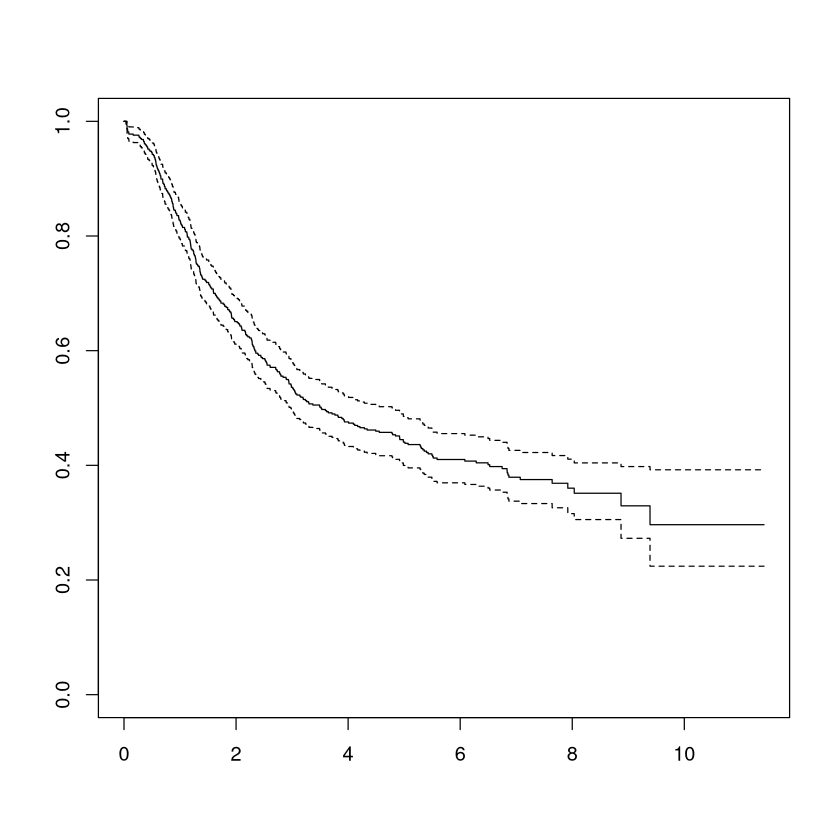

In [23]:
km_fit <- survfit(Surv(df$os_year, df$death_final) ~ 1)
print(km_fit, rmean = "common")
plot(km_fit)

Call: survfit(formula = Surv(bothcensored$os_year, bothcensored$death_final) ~ 
    1)

         n     events     *rmean *se(rmean)     median    0.95LCL    0.95UCL 
   545.000    321.000      5.529      0.212      3.518      2.979      4.783 
    * restricted mean with upper limit =  11.4 


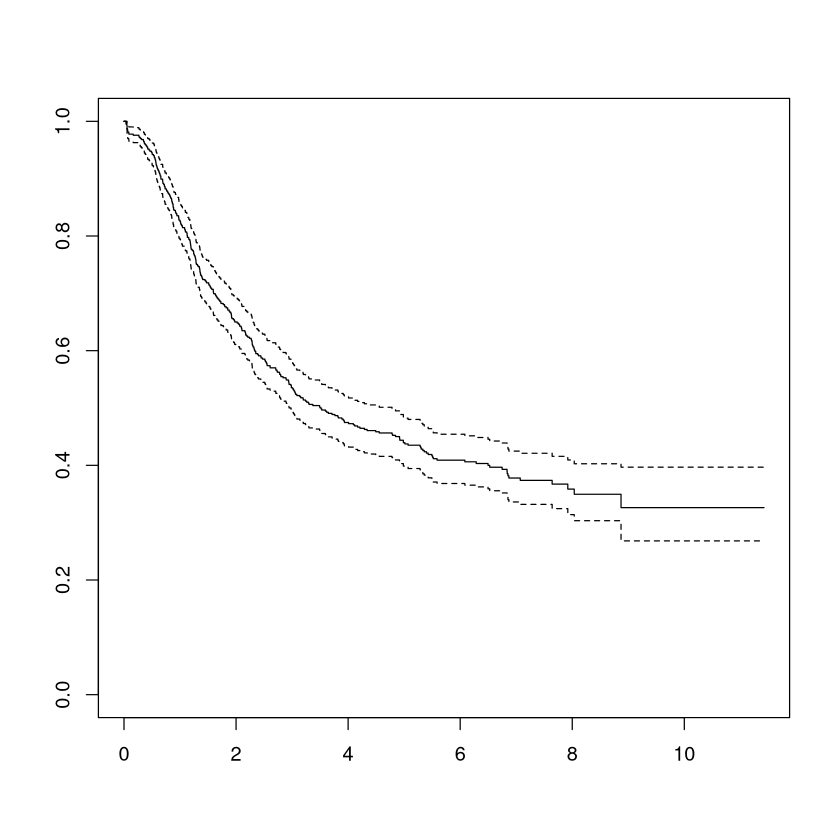

In [25]:
uncensored <- df %>% filter(death_final == 1)
uncensored <- uncensored %>% slice_min(os_year, n = dim(uncensored)[1] - 1)
bothcensored <- rbind(uncensored, filter(df, death_final == 0))
del_largest_k <- survfit(Surv(bothcensored$os_year, bothcensored$death_final) ~ 1)
print(del_largest_k, rmean = "common")
plot(del_largest_k)

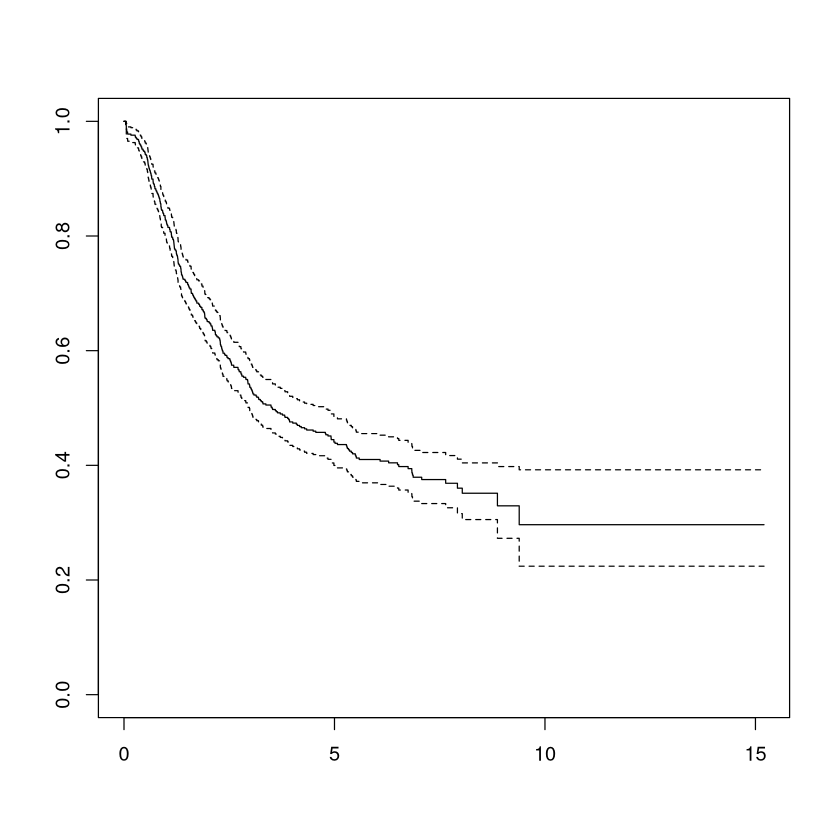

In [12]:
imp_km_fit <- survfit(Surv(imp_os_year, df$death_final) ~ 1)
plot(km_fit)

In [9]:
# Pseudo-observation
ps_mean <- pseudomean(time = df$os_year, event = df$death_final, tmax = floor(max(df$os_year))) # negative values are normal
summary(ps_mean)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
-15.153   1.169   3.400   5.353  10.506  16.691 

# I made a mistake here, the Efron's tail correction has nothing to do with the `impute.survival` function

# The basics of KM estimators

## Non-parametric methods to estimate $S(t)$

Suppose you do not have censored observations, i.e. every subject is follow to death. Then the estimated survivorship function is:

$$
\hat{S}(t_{(i)}) = \frac{n-i}{n} = 1 - \frac{i}{n}
$$

If there are tied observations, such as $t_{(2)} = t_{(3)} = t_{(4)}$, then you choose the largest $i$ for $\hat{S}(t_{(i)})$, which is $i=4$ in this case.

However, if you data consist of censored observations due to any reason, **YOU CANNOT USE THIS METHOD**. The dumb way to do it is going for *reduced-sample estimate*, which is simply removing the incompletely followed-up patients. But this does not utilize all the data. So you need the Kaplan & Meier product limit (PL) method.

$$
\hat{S}(t) = \hat{S}(t-1)p_t
$$
where $p_k$ is the proportion of patients surviving the $k^{th}$ year given they had survived through the $(k-1)^{th}$ year.

### How to estimate $\hat{S}(t)$ using the KM PL method

Construct the following table

| Remission time (t) | Rank (i) | r | $\frac{n-r}{n-r+1}$ | $\hat{S}(t)$ |
|--------------------|----------|---|---------------------|--------------|
|3.0| 1 | 1 | $\frac{9}{10}$ | 0.9|
|4.0+| 2 | - | - | - |
|5.7+| 3 | - | - | - |
|6.5| 4 | 4 | $\frac{6}{7}$ | 0.771|
|...|  |  |  |  |

In other words, let $n$ be the total number of observation regardless of whether they're censored.

$$
\hat{S}(t) = \prod_{t_{(r)} \leq t} \frac{n-r}{n-r+1}
$$

where $r$ are the ranks of the uncensored observations.

The variance of the PL estimate of $\hat{S}(t)$ is

$$
Var[\hat{S}(t)] \cong [\hat{S}(t)]^2 \sum_r \frac{1}{(n-r)(n-r+1)}
$$

If expressed in terms of the number of failure at time $t_{(i)}$, $d_i$.

$$
\hat{S}(t) = \prod_{t_{j=1}}^i \left( 1 - \frac{d_j}{n_j} \right)
$$

and the corresponding variance
$$
Var[\hat{S}(t)] = [\hat{S}(t)]^2 \sum_{j=1}^i \frac{d_j}{n_j(n_j-d_j)}
$$

**In conclusion, you do not get the $\hat{S}(t)$ for censored observations!!!** Let's check the `Surv` object to verify this.

In [ ]:
# Compare both approaches
cmp_df <- data.frame(os_status = df$death_final, 
                     os_length = df$os_year,
                     efron_est = efron_tail,
                     pseudo_est = ps_mean)
cmp_df <- cmp_df[order(cmp_df$os_length),]

print(cmp_df)